# Macaque Cocktail Party Problem

In this notebook, we will address audio source separation applied to macaque coo calls. We begin by generating a synthetic dataset by artificially combining isolated coos into composite waveforms, inspired by the human speech-based approach of constructing the WSJ0-2Mix dataset. Using this dataset, we develop and train a custom neural network to separate the overlapping calls into the respective sources. This notebook represents a complete pipeline, but there remain a number of opportunities for optimization.

Let's get started!

## Imports

We need a couple of imports:

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install git+git://github.com/fastai/fastai.git
    !pip install soundfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
from pathlib import Path
import librosa

from IPython.display import Audio

try:
    from fastai.vision.all import untar_data, get_files
except:
    from fastai2.vision.all import untar_data, get_files

import soundfile as sf
import scipy.signal
from sklearn.model_selection import train_test_split

import pathlib
from IPython.display import Audio
import functools
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

We also import the ```Trainer``` object from the custom PyFire module:

In [2]:
from PyFire_V3 import Trainer

## Data

For this analysis, we'll be using the macaque coo dataset in the [ESP Library](https://github.com/earthspecies/library). It consists of coo calls produced by eight independent macaques, of which four are male and four are female. The methods for preprocessing the dataset are available and explicated in the [ESP Representation Toolbox](https://github.com/earthspecies/representation-toolbox), so we'll simply apply them here with limited explanation.

In [3]:
SR=24414
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

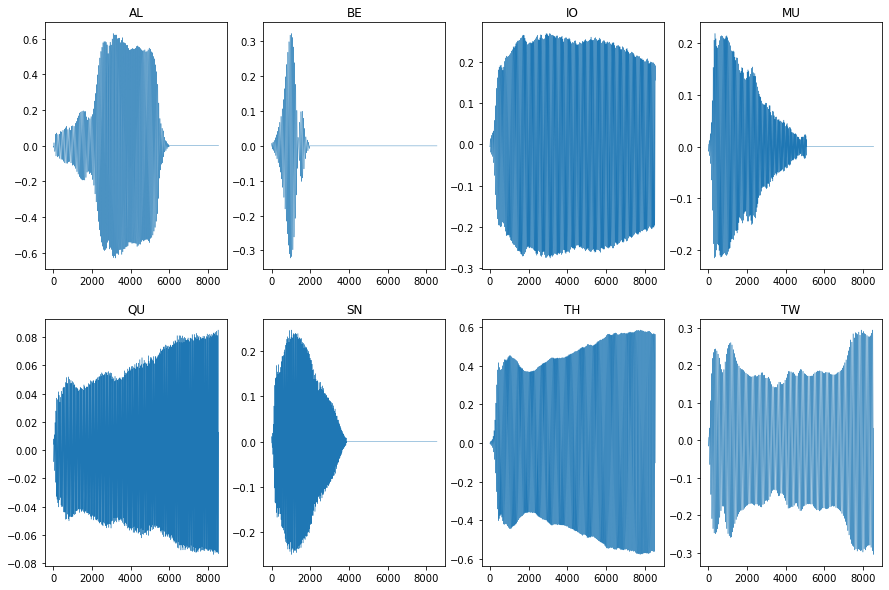

In [4]:
class LoadData(object):    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [5]:
WINDOW_WIDTH = mean_dur

In [6]:
X = np.zeros((len(data_df), WINDOW_WIDTH), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X[i, :] = wf
Y=data_df.Category.values
X.shape, Y.shape

((3744, 8549), (3744,))

Great! Now we have all the coo calls loaded into an array `X` with the associated identity labels `Y`. Next, we need to build our dataset of overlapping calls. In the [CPP perceptual playground notebook](http://localhost:2222/notebooks/Cocktail-Party-Problem/Perceptual-Integration-and-Segregation/Harmonicity.ipynb), we investigate some of the spectrotemporal acoustic cues that might enable the animal brain to solve the cocktail party problem. These include features such as harmonicity mistuning, onset/offset asynchrony, fundamental frequency f0 differencies, and frequency separation $\Delta f$, among others. While a thorough investigation might involve considering all these cues when constructing a synthetic dataset, for the purposes of this notebook, we'll construct a dataset as quickly as we can in order to get to the fun part: training the model!

To proceed with this proof-of-concept exploration, we'll combine 'BE' calls with 'QU' calls and 'SN' calls with 'TW' calls.m

In [7]:
X_be, X_qu = X[Y == 1], X[Y == 4] 
X_sn, X_tw = X[Y == 5], X[Y == 7] 
X_be.shape, X_qu.shape, X_sn.shape, X_tw.shape

((468, 8549), (468, 8549), (468, 8549), (468, 8549))

In [8]:
X_bq = np.expand_dims(X_be+X_qu, axis=1)
Y_be = np.expand_dims(X_be, axis=1)
Y_qu = np.expand_dims(X_qu, axis=1)
Y_bq = np.concatenate([Y_be, Y_qu], axis=1)
X_bq.shape, Y_bq.shape

((468, 1, 8549), (468, 2, 8549))

In [9]:
X_st = np.expand_dims(X_sn+X_tw, axis=1)
Y_sn = np.expand_dims(X_sn, axis=1)
Y_tw = np.expand_dims(X_tw, axis=1)
Y_st = np.concatenate([Y_sn, Y_tw], axis=1)
X_st.shape, Y_st.shape

((468, 1, 8549), (468, 2, 8549))

In [10]:
X = np.concatenate([X_bq, X_st], axis=0)
Y = np.concatenate([Y_bq, Y_st], axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((748, 1, 8549), (188, 1, 8549), (748, 2, 8549), (188, 2, 8549))

Let's see what this sounds like! For the overlapping input:

In [11]:
Audio(np.squeeze(X_train[0]), rate=SR)

And for the separated ground truths:

In [12]:
Audio(np.squeeze(Y_train[0, 0, :]), rate=SR)

In [13]:
Audio(np.squeeze(Y_train[0, 1, :]), rate=SR)

Now we'll prepare our dataloaders:

In [14]:
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

In [15]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=2,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=2,
                                               shuffle=True)

Great! Time to build the model!

## Building the Model

For this analysis, we'll be constructing a custom neural architecture from scratch. While there are a number of models that have yielded promising results in the human speech and music domains, we aim to develop a lightweight model designed to account for some of the major differences between human speech and animal vocalizations. Many of the existing models are computationally taxing, even when working with human speech data that has been downsampled to 8kHz. While this might suffice for working with macaque coo calls, this would clearly be inadequate for other organisms, such as dolphins or bats, which can generate vocalizations on the order of 10-100kHz. For dolphin whistles, which can reach ~15kHz and last seconds in duration, we would demand a sampling rate >30kHz in order to avoid Nyquist-associated aliasing. This requirement leads to large amounts of data that might push existing approaches to their limits. For this reason, we focus on a super lightweight model inspired by the popular UNet architecture.

Firstly, our model begins with a 1D convolutional layer that acts as a learnable filterbank somewhat similar to a spectrogram. We then pass this encoded representation into a CNN-based UNet with residual connections, which culminates in a 2D conv layer with kernel size (1,1) and 2 filters in order to separate the stream into 2 channels. Lastly, we perform the inverse conv operation using a 1D convolutional transpose layer, which essentially acts as an inverse STFT to return to the time demain raw audio.

Before we begin, we need to decide some of the parameters to use for the 1D conv layers. The UNet is comprised of 4 conv blocks, which results in a downsampling by a factor of 2^4=16, so we'll opt for an output shape that is cleanly divisible by 16 such as 256. For the Conv1D layer, we can explore some options:

In [17]:
def out_size(in_size=8549, k=512, s=1):
    return (in_size - (k-1)) // s + 1

def out_params(in_size=8549, max_k=512, out_size=256):
    params = []
    for k in range(1, max_k):
        for s in range(1, k):
            out = (in_size - (k-1)) // s + 1
            if out == 256:
                params.append((k,s))
    return params

In [18]:
out_size(k=128, s=33)

256

Now for the transpose conv1d, we might need to pad the result in order to yield the appropriate number of time steps:

In [19]:
def out_size_t(in_size=256, k=128, s=33, pad=0, opad=0):
    out = (in_size-1)*s + k-2*pad + opad
    return out

def out_padding(out_size=8549, in_size=256, k=128, s=33, pad=0, opad=0):
    out = out_size_t(in_size=in_size, k=k, s=s, pad=pad, opad=0)
    pad = out_size - out
    return pad
out_padding()

6

Great! We need one final ingredient to build the model. We'll define a simple layer to split the channels in order to carry out the inverse conv transform.

In [20]:
class SplitChannels(nn.Module):
    def __init__(self, n_src=2):
        super(SplitChannels, self).__init__()
        self.n_src = 2
        
    def forward(self, x):
        split_size = [1 for _ in range(self.n_src)]
        x = torch.split(x, split_size_or_sections=split_size, dim=1)
        return x

In [21]:
def conv_block(in_filters, out_filters):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_filters,
                  out_channels=out_filters,
                  kernel_size=(3,3),
                  padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=out_filters,
                  out_channels=out_filters,
                  kernel_size=(3,3),
                  padding=1),
        nn.LeakyReLU())
    return block

In [22]:
class UNet(nn.Module):
    def __init__(self, n_src=2):
        super(UNet, self).__init__()
        self.n_src = n_src
        
        self.conv1d = nn.Conv1d(in_channels=1, 
                                out_channels=512, 
                                kernel_size=128, 
                                stride=33)
        
        self.down1 = conv_block(1, 16)
        self.down2 = conv_block(16, 32)
        self.down3 = conv_block(32, 64)
        self.down4 = conv_block(64, 128)
        
        self.conv_middle1 = nn.Conv2d(in_channels=128, 
                                      out_channels=128, 
                                      kernel_size=(3,3),
                                      padding=1)
        self.conv_middle2 = nn.Conv2d(in_channels=128, 
                                      out_channels=128, 
                                      kernel_size=(3,3),
                                      padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=True)
        
        self.up4 = conv_block(256, 128)
        self.up3 = conv_block(192, 64)
        self.up2 = conv_block(96, 32)
        self.up1 = conv_block(48, 16)
        
        self.conv_last = nn.Conv2d(in_channels=16,
                                   out_channels=n_src,
                                   kernel_size=(1,1))
        self.conv1d_t1 = nn.ConvTranspose1d(in_channels=512,
                                        out_channels=1,
                                        kernel_size=128,
                                        stride=33,
                                        output_padding=6)
        self.conv1d_t2 = nn.ConvTranspose1d(in_channels=512,
                                        out_channels=1,
                                        kernel_size=128,
                                        stride=33,
                                        output_padding=6)
        
    def forward(self, x):
        filterbank = self.conv1d(x)
        filterbank = torch.unsqueeze(filterbank, dim=1)
        
        down1 = self.down1(filterbank)
        pool1 = self.maxpool(down1)

        down2 = self.down2(pool1)
        pool2 = self.maxpool(down2)

        down3 = self.down3(pool2)
        pool3 = self.maxpool(down3)

        down4 = self.down4(pool3)
        pool4 = self.maxpool(down4)

        middle = F.leaky_relu(self.conv_middle1(pool4))
        middle = F.leaky_relu(self.conv_middle2(middle))

        upsample4 = self.upsample(middle)
        concat = torch.cat([upsample4, down4], dim=1)
        up4 = self.up4(concat)
        
        upsample3 = self.upsample(up4)
        concat = torch.cat([upsample3, down3], dim=1)
        up3 = self.up3(concat)
        
        upsample2 = self.upsample(up3)
        concat = torch.cat([upsample2, down2], dim=1)
        up2 = self.up2(concat)
        
        upsample1 = self.upsample(up2)
        concat = torch.cat([upsample1, down1], dim=1)
        up1 = self.up1(concat)

        x = self.conv_last(up1)
        x1, x2 = SplitChannels(n_src=self.n_src)(x)
        
        x1 = torch.mul(x1, filterbank)
        x2 = torch.mul(x2, filterbank)
        
        x1 = torch.squeeze(x1, dim=1)
        x2 = torch.squeeze(x2, dim=1)
        
        x1 = self.conv1d_t1(x1)
        x2 = self.conv1d_t2(x2)
        
        x = torch.cat([x1, x2], dim=1)
        return x

Now it's time to compile the model using the mean absolute error and Adam optimizer. We could opt for a more advanced loss function, such as a permutation-invariant loss, but for this first pass, we'll keep things relatively straightforward. Also, to investigate the performance of our model, we'll use the scale-invariant signal-to-distortion ratio (SI-SDR) as our metric.

In [23]:
def si_sdr(reference, estimation):
    reference_energy = torch.sum(torch.pow(reference, 2), dim=-1, keepdim=True)
    opt_scaling = torch.true_divide(torch.sum(torch.mul(reference, estimation), dim=-1, keepdim=True), reference_energy)
    projection = torch.mul(opt_scaling, reference)
    noise = torch.sub(estimation, projection)
    ratio = torch.true_divide(torch.sum(torch.pow(projection, 2), dim=-1), torch.sum(torch.pow(noise, 2), dim=-1))
    return torch.mean(torch.mul(torch.log10(ratio), 10))

In [24]:
model = UNet(n_src=2)
model.cuda()
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(model.parameters()))}')
summary(model)

loss_func = F.l1_loss
metric_func = si_sdr
optimizer = optim.Adam(model.parameters(), lr=1e-4)

> Number of parameters 1421940
Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            66,048
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1                       160
|    └─LeakyReLU: 2-2                    --
|    └─Conv2d: 2-3                       2,320
|    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-5                       4,640
|    └─LeakyReLU: 2-6                    --
|    └─Conv2d: 2-7                       9,248
|    └─LeakyReLU: 2-8                    --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-9                       18,496
|    └─LeakyReLU: 2-10                   --
|    └─Conv2d: 2-11                      36,928
|    └─LeakyReLU: 2-12                   --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      73,856
|    └─LeakyReLU: 2-14                   --
|    └─Conv2d: 2-15                      147,584
|    └─Le

Time to train!

## Training the Model

For convenience, we'll use the custom PyFire module to fit the model. This can be done easily as follows:

Epoch: 74 >>>>>>>>>>>>>> Loss: 0.00250176547516358 - Metric: 25.00576926079779 --- Val Loss: 0.0029130630514973247 - Val Metric 24.37235776053327 ---------------- 37s: 10.11it/s


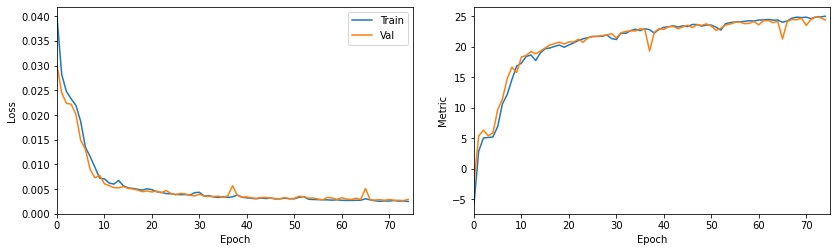

In [25]:
trainer = Trainer(model, loss_func, optimizer, metric_func=si_sdr, verbose=2, device='cuda')
trainer.fit(train_dataloader, test_dataloader, epochs=75)

## Evaluating the Model

Now that we have trained the model, we can proceed to evaluate the performance, once again making use of PyFire.

In [26]:
inputs_train, preds_train, truths_train = trainer.evaluate(train_dataloader)

100%|██████████| 374/374 [01:28<00:00,  4.23it/s]


Evaluation >>>>>>>>>>>>>>>> Loss: 0.002687770174816251 - Metric 24.744125366210938


In [27]:
inputs_test, preds_test, truths_test = trainer.evaluate(test_dataloader)

100%|██████████| 94/94 [00:21<00:00,  4.47it/s]

Evaluation >>>>>>>>>>>>>>>> Loss: 0.0028845465276390314 - Metric 24.108835220336914


## Exploring the Results

### Listening to the Calls

Let's inspect some of the results of our trained source separation model.

In [28]:
from IPython.display import display, clear_output
from ipywidgets import Button, interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [29]:
def plot_separations(X, Y, trainer, index, window=WINDOW_WIDTH, sr=SR):
    
    t = np.linspace(0, window/sr, window)
    X_input = torch.unsqueeze(X_train[index, :, :], dim=0)
    Y0 = Y[index, 0, :]
    Y1 = Y[index, 1, :]
    out0 = trainer.predict(X_input)[0, 0, :]
    out1 = trainer.predict(X_input)[0, 1, :]
    
    fig, axes = plt.subplots(1,5, figsize=(20,4))
    axes[0].plot(t, np.squeeze(X_input.numpy()))
    axes[0].set_xlabel('Time (s)')
    axes[0].set_title('Mixture')
    axes[0].set_ylabel('Amplitude')
    axes[1].plot(t, Y0.numpy())
    axes[1].set_xlabel('Time (s)')
    axes[1].set_title('Source 1')
    axes[2].plot(t, Y1.numpy())
    axes[2].set_xlabel('Time (s)')
    axes[2].set_title('Source 2')
    axes[3].plot(t, np.squeeze(out0.numpy()))
    axes[3].set_xlabel('Time (s)')
    axes[3].set_title('Separated 1')
    axes[4].plot(t, np.squeeze(out1.numpy()))
    axes[4].set_xlabel('Time (s)')
    axes[4].set_title('Separated 2')
    plt.show()
    
    audios = [np.squeeze(X_input.numpy()), Y0.numpy(), Y1.numpy(),
              np.squeeze(out0.numpy()), np.squeeze(out1.numpy())]
    labels = ['Mixture', 'Source 1', 'Source 2', 'Separated 1', 'Separated 2']
    

    buttons_list = [widgets.Button(description=labels[i]) for i in range(5)]
    out = widgets.Output()
    def button_0_clicked(_, i=0):
        with out:
            clear_output()
            display(Audio(audios[i], rate=sr))
    
    def button_1_clicked(_):
        return button_0_clicked(_,i=1)
    def button_2_clicked(_):
        return button_0_clicked(_,i=2)
    def button_3_clicked(_):
        return button_0_clicked(_,i=3)
    def button_4_clicked(_):
        return button_0_clicked(_,i=4)
    
    buttons_list[0].on_click(button_0_clicked)    
    buttons_list[1].on_click(button_1_clicked)
    buttons_list[2].on_click(button_2_clicked)
    buttons_list[3].on_click(button_3_clicked)
    buttons_list[4].on_click(button_4_clicked)
        
    buttons = widgets.HBox(buttons_list)
    display(widgets.VBox([buttons, out]))

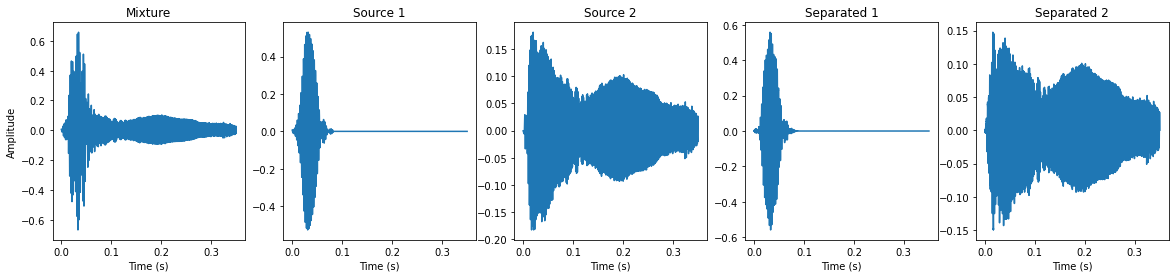

In [30]:
plot_separations(X_train, Y_train, trainer, 1)

In [31]:
interact_manual(lambda index: plot_separations(X_train, Y_train, trainer, index), 
                index=widgets.IntSlider(min=0, max=10, step=1));

interactive(children=(IntSlider(value=0, description='index', max=10), Button(description='Run Interact', styl…

Wow! It sounds like our UNet separator has learned to separate sources!

### Comparing Spectrograms

We can visually investigate the results not only by looking at the time domain audio waveforms, but we can also look at spectrogram representations.

In [32]:
def compute_spectrogram(data, nfft=1024, hop=1024//4, sr=SR, e=1e-4):
    _, _, S = librosa.reassigned_spectrogram(data, n_fft=nfft, hop_length=hop, sr=sr)
    D = librosa.amplitude_to_db(np.abs(S) + e, ref=np.max)
    return D

def plot_spectrograms(X, Y, trainer, index, window=WINDOW_WIDTH, sr=SR):
    
    t = np.linspace(0, window/sr, window)
    X_input = torch.unsqueeze(X_train[index, :, :], dim=0)
    Y0 = Y[index, 0, :]
    Y1 = Y[index, 1, :]
    out0 = trainer.predict(X_input)[0, 0, :]
    out1 = trainer.predict(X_input)[0, 1, :]
    
    D_X = compute_spectrogram(np.squeeze(X_input.numpy()))
    D_Y0 = compute_spectrogram(Y0.numpy())
    D_Y1 = compute_spectrogram(Y1.numpy())
    D_S0 = compute_spectrogram(np.squeeze(out0.numpy()))
    D_S1 = compute_spectrogram(np.squeeze(out1.numpy()))
    
    fig, axes = plt.subplots(1,5, figsize=(20,4))
    axes[0].imshow(D_X, aspect='auto', cmap='magma')
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Time')
    axes[0].set_title('Mixture')
    axes[0].set_ylabel('Frequency')
    
    axes[1].imshow(D_Y0, aspect='auto', cmap='magma')
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Time (s)')
    axes[1].set_title('Source 1')
    
    axes[2].imshow(D_Y1, aspect='auto', cmap='magma')
    axes[2].invert_yaxis()
    axes[2].set_xlabel('Time')
    axes[2].set_title('Source 2')
    
    axes[3].imshow(D_S0, aspect='auto', cmap='magma')
    axes[3].invert_yaxis()
    axes[3].set_xlabel('Time')
    axes[3].set_title('Separated 1')
    
    axes[4].imshow(D_S1, aspect='auto', cmap='magma')
    axes[4].invert_yaxis()
    axes[4].set_xlabel('Time')
    axes[4].set_title('Separated 2')
    plt.show()

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)


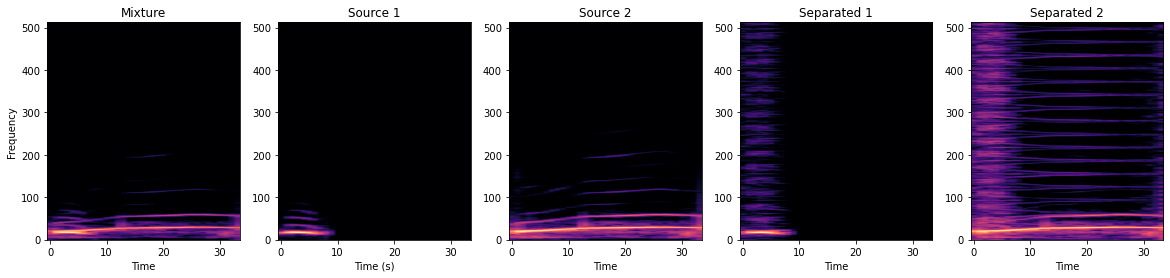

In [33]:
plot_spectrograms(X_train, Y_train, trainer, 1)

In [34]:
interact_manual(lambda index: plot_spectrograms(X_train, Y_train, trainer, index), 
                index=widgets.IntSlider(min=0, max=10, step=1));

interactive(children=(IntSlider(value=0, description='index', max=10), Button(description='Run Interact', styl…

### An Artificial Example

While our approach to constructing the synthetic dataset is somewhat artificial, it is instructive to consider slightly longer audio streams. Just for demonstration purposes, we can achieve this as follows:

In [35]:
n_examples = 5
signals = [X_train[0+i:1+i] for i in range(n_examples)]
input_signal = torch.cat(signals, dim=-1)

Let's listen to this example and plot the raw waveform:

In [36]:
Audio(np.squeeze(input_signal.numpy()), rate=SR)

Text(0.5, 1.0, 'Mixture')

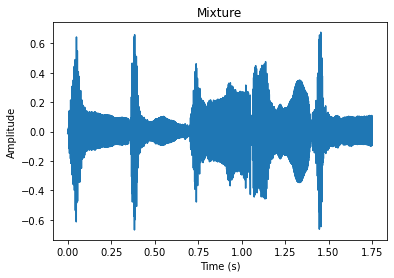

In [37]:
t = np.linspace(0, WINDOW_WIDTH*n_examples/SR, WINDOW_WIDTH*n_examples)
plt.plot(t, np.squeeze(input_signal.numpy()))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Mixture')

Let's check our model's performance:

In [38]:
preds = []
for i in range(n_examples):
    preds.append(trainer.predict(signals[i]))
output_preds = torch.cat(preds, dim=-1)

We can plot the waveforms and play the audio and compare to the ground truths:

In [39]:
sources_gt = [Y_train[0+i:1+i] for i in range(n_examples)]
outputs_gt = torch.cat(sources_gt, dim=-1)

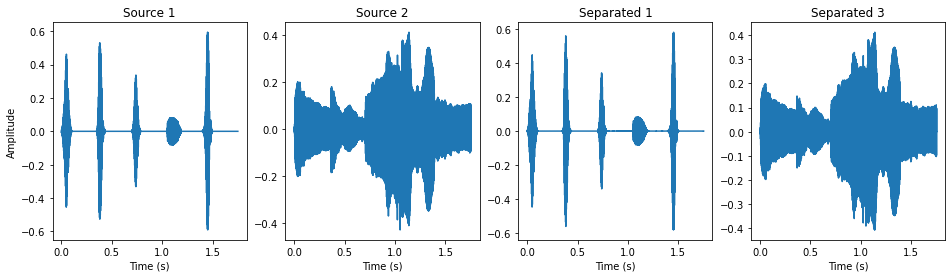

In [40]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].plot(t, np.squeeze(outputs_gt[0, 0, :].numpy()))
axes[0].set_title('Source 1')
axes[1].plot(t, np.squeeze(outputs_gt[0, 1, :].numpy()))
axes[1].set_title('Source 2')
axes[2].plot(t, np.squeeze(output_preds[0, 0, :].numpy()))
axes[2].set_title('Separated 1')
axes[3].plot(t, np.squeeze(output_preds[0, 1, :].numpy()))
axes[3].set_title('Separated 3')
for i in range(4):
    axes[i].set_xlabel('Time (s)')
    if i == 0:
        axes[i].set_ylabel('Amplitude')

In [47]:
print('Source 1')
display(Audio(np.squeeze(outputs_gt[0, 0, :].numpy()), rate=SR))
print('Source 2')
display(Audio(np.squeeze(outputs_gt[0, 1, :].numpy()), rate=SR))
print('Separated 1')
display(Audio(np.squeeze(output_preds[0, 0, :].numpy()), rate=SR))
print('Separated 2')
display(Audio(np.squeeze(output_preds[0, 1, :].numpy()), rate=SR))

Source 1


Source 2


Separated 1


Separated 2


## Exploring the Encoded Representation

With our trained model, we can extract intermediate layers in order to visualize the deep learned encoded representation. For instance, passing the raw audio through the 1D convolutional layer yields a pseudo-spectrogram-like representation.

In [42]:
trained_model = model
for p in trained_model.parameters():
    p.requires_grad = False

In [43]:
deep_input = nn.Sequential(*[_ for i, _ in enumerate(trained_model.children()) if i==0])
summary(deep_input)

mixture = X_train[0:1]
deep_representation = deep_input(mixture).detach().squeeze().numpy()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            (66,048)
Total params: 66,048
Trainable params: 0
Non-trainable params: 66,048


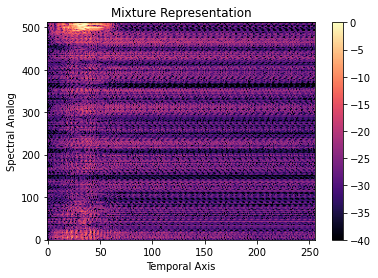

In [44]:
plt.figure()
plt.imshow(20*np.log10(np.abs(deep_representation) + 1e-18), aspect='auto', cmap='magma', vmin=-40, vmax=0)
plt.gca().invert_yaxis()
plt.xlabel('Temporal Axis')
plt.ylabel('Spectral Analog')
plt.title('Mixture Representation')
plt.colorbar()
plt.show()

We can also look at deeper layers to see the separated representations:

In [45]:
def deep_separations(x, trained_model):
    filterbank = trained_model.conv1d(x)
    filterbank = torch.unsqueeze(filterbank, dim=1)

    down1 = trained_model.down1(filterbank)
    pool1 = trained_model.maxpool(down1)

    down2 = trained_model.down2(pool1)
    pool2 = trained_model.maxpool(down2)

    down3 = trained_model.down3(pool2)
    pool3 = trained_model.maxpool(down3)

    down4 = trained_model.down4(pool3)
    pool4 = trained_model.maxpool(down4)

    middle = F.leaky_relu(trained_model.conv_middle1(pool4))
    middle = F.leaky_relu(trained_model.conv_middle2(middle))

    upsample4 = trained_model.upsample(middle)
    concat = torch.cat([upsample4, down4], dim=1)
    up4 = trained_model.up4(concat)

    upsample3 = trained_model.upsample(up4)
    concat = torch.cat([upsample3, down3], dim=1)
    up3 = trained_model.up3(concat)

    upsample2 = trained_model.upsample(up3)
    concat = torch.cat([upsample2, down2], dim=1)
    up2 = trained_model.up2(concat)

    upsample1 = trained_model.upsample(up2)
    concat = torch.cat([upsample1, down1], dim=1)
    up1 = trained_model.up1(concat)

    x = trained_model.conv_last(up1)
    x1, x2 = SplitChannels(n_src=trained_model.n_src)(x)

    x1 = torch.mul(x1, filterbank)
    x2 = torch.mul(x2, filterbank)

    x1 = torch.squeeze(x1, dim=1)
    x2 = torch.squeeze(x2, dim=1)
    
    return [x1, x2]

deep_sep1, deep_sep2 = deep_separations(mixture, trained_model)
deep_sep1 = deep_sep1.squeeze().numpy()
deep_sep2 = deep_sep2.squeeze().numpy()

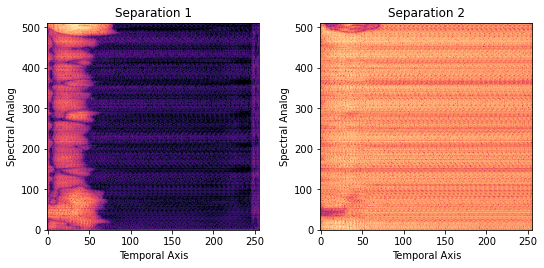

In [60]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout(pad=3)
axes[0].imshow(20*np.log10(np.abs(deep_sep1) + 1e-18), aspect='auto', cmap='magma', vmin=-130)
axes[0].invert_yaxis()
axes[0].set_xlabel('Temporal Axis')
axes[0].set_ylabel('Spectral Analog')
axes[0].set_title('Separation 1')

axes[1].imshow(20*np.log10(np.abs(deep_sep2) + 1e-18), aspect='auto', cmap='magma', vmin=-130)
axes[1].invert_yaxis()
axes[1].set_xlabel('Temporal Axis')
axes[1].set_ylabel('Spectral Analog')
axes[1].set_title('Separation 2')
plt.show()